In [1]:
ADITYA_EPOCH_UNIX = 1693612800  # 2023-09-02T00:00:00 UTC

%pip install sunpy astropy sherpa matplotlib fitsio tqdm -q

from pathlib import Path
from io import BytesIO
from tqdm.auto import tqdm
from IPython.display import Markdown
import zipfile, gzip, io

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from astropy.io import fits
from astropy.table import Table
from astropy.time import Time

# import sherpa

# import sunpy

Note: you may need to restart the kernel to use updated packages.


/Users/home/anaconda3/envs/labo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = Path('data')
zips     = sorted(data_dir.glob('AL1_SLX_L1_*_v1.0.zip'))
if not zips:
    raise FileNotFoundError("No Aditya-L1 ZIPs in data/")
latest   = zips[-1]

print(f"Most recent data file: {latest.name}")

# Extract and open FITS in-memory
with zipfile.ZipFile(latest, 'r') as z:
    member = next(m for m in z.namelist() if '/SDD2/' in m and m.endswith('.lc.gz'))
    raw    = z.read(member)

with gzip.GzipFile(fileobj=io.BytesIO(raw)) as dec, fits.open(dec) as hdul:

    # Build the “hdul.info()” table
    info = []
    for idx, hdu in enumerate(hdul):
        hdr      = hdu.header
        name     = hdr.get('EXTNAME', 'PRIMARY').strip()
        ver      = hdr.get('EXTVER', 1)
        hdu_type = type(hdu).__name__.replace('HDU','HDU')
        cards    = len(hdr)
        if hdu.data is not None:
            nrows   = hdr.get('NAXIS2','')
            nfields = hdr.get('TFIELDS','')
            dims    = f"{nrows}R x {nfields}C"
            tforms  = [hdr.get(f"TFORM{i}",'') for i in range(1, int(nfields)+1)]
            fmt     = f"[{', '.join(tforms)}]"
        else:
            dims, fmt = '', ''
        info.append({
            "No.":        idx,
            "Name":       name,
            "Ver":        ver,
            "Type":       hdu_type,
            "Cards":      cards,
            "Dimensions": dims,
            "Format":     fmt
        })

    df_info = pd.DataFrame(info)
    display(Markdown(df_info.to_markdown(index=False)))

    # Render full headers for HDU0 & HDU1
    for idx, title in ((0, "Primary HDU"), (1, "Table HDU")):
        hdr = hdul[idx].header
        df  = pd.DataFrame([
            {"Keyword": k, "Value": hdr[k], "Comment": hdr.comments[k]}
            for k in hdr.keys()
        ])
        display(Markdown(f"## {title} Header\n" + df.to_markdown(index=False)))

Most recent data file: AL1_SLX_L1_20250331_v1.0.zip


|   No. | Name    |   Ver | Type        |   Cards | Dimensions   | Format   |
|------:|:--------|------:|:------------|--------:|:-------------|:---------|
|     0 | PRIMARY |     1 | PrimaryHDU  |      15 |              |          |
|     1 | RATE    |     1 | BinTableHDU |      39 | 86400R x 2C  | [D, D]   |

## Primary HDU Header
| Keyword   | Value                          | Comment                                        |
|:----------|:-------------------------------|:-----------------------------------------------|
| SIMPLE    | True                           | conforms to FITS standard                      |
| BITPIX    | 8                              | array data type                                |
| NAXIS     | 0                              | number of array dimensions                     |
| EXTEND    | True                           |                                                |
| MISSION   | ADITYA-L1                      | Name of mission/satellite                      |
| TELESCOP  | AL1                            | Name of mission/satellite                      |
| INSTRUME  | SoLEXS                         | Name of Instrument/detector                    |
| ORIGIN    | SoLEXSPOC                      | Source of FITS file                            |
| CREATOR   | solexs_pipeline-1.2            | Creator of file                                |
| FILENAME  | AL1_SOLEXS_20250331_SDD2_L1.lc | Name of file                                   |
| CONTENT   | LIGHT CURVE                    | File content                                   |
| DATE      | 2025-04-08                     | Creation Date                                  |
| OBS_DATE  | 20250331                       |                                                |
| OBS_ID    | N00_0000_000474                |                                                |
| DATASUM   | 0                              | data unit checksum updated 2025-04-08T17:24:36 |

## Table HDU Header
| Keyword   | Value                     | Comment                                         |
|:----------|:--------------------------|:------------------------------------------------|
| XTENSION  | BINTABLE                  | binary table extension                          |
| BITPIX    | 8                         | array data type                                 |
| NAXIS     | 2                         | number of array dimensions                      |
| NAXIS1    | 16                        | length of dimension 1                           |
| NAXIS2    | 86400                     | length of dimension 2                           |
| PCOUNT    | 0                         | number of group parameters                      |
| GCOUNT    | 1                         | number of groups                                |
| TFIELDS   | 2                         | number of table fields                          |
| EXTNAME   | RATE                      | Extension name                                  |
| CONTENT   | LIGHT CURVE               | File content                                    |
| HDUCLASS  | OGIP                      | format conforms to OGIP standard                |
| HDUVERS   | 1.1.0                     | Version of format (OGIP memo CAL/GEN/92-002a)   |
| HDUDOC    | OGIP memos CAL/GEN/92-007 | Documents describing the format                 |
| HDUVERS1  | 1.0.0                     | Obsolete - included for backwards compatibility |
| HDUVERS2  | 1.1.0                     | Obsolete - included for backwards compatibility |
| HDUCLAS1  | LIGHTCURVE                | Extension contains spectral data                |
| HDUCLAS2  | TOTAL                     |                                                 |
| HDUCLAS3  | COUNTS                    |                                                 |
| FILTER    | SDD2                      | Filter used                                     |
| TTYPE1    | TIME                      |                                                 |
| TFORM1    | D                         |                                                 |
| TTYPE2    | COUNTS                    |                                                 |
| TFORM2    | D                         |                                                 |
| CREATOR   | solexs_pipeline-1.2       |                                                 |
| TSTART    | 1743379200.0              |                                                 |
| TSTOP     | 1743465599.0              |                                                 |
| TIMEDEL   | 1                         |                                                 |
| TIMZERO   | 0                         |                                                 |
| MJDREFI   | 40587                     |                                                 |
| MJDREFF   | 0                         |                                                 |
| TIMESYS   | UTC                       |                                                 |
| TIMEREF   | LOCAL                     |                                                 |
| TIMEUNIT  | s                         |                                                 |
| DATE-OBS  | 2025-03-31 00:00:00       |                                                 |
| DATE-END  | 2025-03-31 23:59:59       |                                                 |
| TELESCOP  | AL1                       |                                                 |
| INSTRUME  | SoLEXS                    |                                                 |
| NUMBAND   | 4                         |                                                 |
| DATASUM   | 2065465298                | data unit checksum updated 2025-04-08T17:24:36  |

In [13]:
def load_solexs_data(data_dir='data',
                     pattern='AL1_SLX_L1_*_v1.0.zip',
                     out_parquet='SoLEXS_dataset.parquet') -> pd.DataFrame:
    data_dir = Path(data_dir)
    zips     = sorted(data_dir.glob(pattern))
    all_dfs  = []
    for zp in tqdm(zips, desc='Loading FITS data', unit=' files', leave=True):
        day = zp.stem.split('_')[3]
        internal = f"{zp.stem}/SDD2/AL1_SOLEXS_{day}_SDD2_L1.lc.gz"

        # read & decompress
        with zipfile.ZipFile(zp) as zf:
            raw = zf.read(internal)
        with gzip.GzipFile(fileobj=io.BytesIO(raw)) as dec:
            # use Table to auto‐fix endianness
            table = Table.read(dec, format='fits')

        df = table.to_pandas()
        df['DATE'] = pd.to_datetime(day, format='%Y%m%d')
        df['TIME'] = df['TIME'].astype(int)
        df['COUNTS'] = df['COUNTS'].astype('Int64')
        all_dfs.append(df[['DATE','TIME','COUNTS']])

    master = pd.concat(all_dfs, ignore_index=True)
    master.to_parquet(out_parquet, index=False)
    return master

# run it
SoLEXS_df = load_solexs_data()
display(SoLEXS_df)

Loading FITS data: 100%|██████████| 26/26 [00:00<00:00, 61.92 files/s]


,DATE,TIME,COUNTS
0,2025-03-01,1740787200,59
1,2025-03-01,1740787201,58
2,2025-03-01,1740787202,54
3,2025-03-01,1740787203,50
4,2025-03-01,1740787204,66
...,...,...,...
2246395,2025-03-31,1743465595,75
2246396,2025-03-31,1743465596,88
2246397,2025-03-31,1743465597,78
2246398,2025-03-31,1743465598,79


In [14]:
display(SoLEXS_df.loc[:, ['DATE', 'TIME']].apply(['min', 'max'], axis=0))
display(SoLEXS_df.describe().loc[:, ['COUNTS']].T.astype(int))

,DATE,TIME
min,2025-03-01,1740787200
max,2025-03-31,1743465599


,count,mean,min,25%,50%,75%,max,std
COUNTS,2119175,53,0,16,24,40,8084,218


In [73]:
start_date = '2025-03-01'
end_date   = '2025-03-07'

df = SoLEXS_df[(SoLEXS_df['DATE'] >= start_date) & (SoLEXS_df['DATE'] <= end_date)].copy()
display(df.loc[:, ['DATE', 'TIME']].apply(['min', 'max'], axis=0))
display(df.describe().loc[:, ['COUNTS']].T.astype(int))

gap = 60    # Seconds of inactivity to split events
sigma = 5   # Threshold = median + sigma * std

times = df['TIME']
counts = df['COUNTS']

# Return sorted unique unix times where counts exceed median + sigma*std.
med, std = np.nanmedian(counts), np.nanstd(counts)
mask = counts > (med + sigma*std)
spikes = np.unique(times[mask])

if spikes.size == 0:
    print("No flares detected.")
else:
    groups = [[spikes[0]]]
    for t in spikes[1:]:
        if t - groups[-1][-1] <= gap:
            groups[-1].append(t)
        else:
            groups.append([t])
    events = [(g[0], g[-1]) for g in groups]
    for i, ev in enumerate(events, 1):
        t0, t1 = Time(ev[0], format='unix'), Time(ev[1], format='unix')
        # midnight of that day:
        mid = Time(t0.iso[:10]+'T00:00:00', format='isot', scale='utc')
        info = {'start_iso': t0.iso,
                'end_iso':   t1.iso,
                'start_sod': (t0 - mid).sec,
                'end_sod':   (t1 - mid).sec}
        print(f"Flare {i}: {info['start_iso']} → {info['end_iso']}")
    

,DATE,TIME
min,2025-03-01,1740787200
max,2025-03-07,1741391999


,count,mean,min,25%,50%,75%,max,std
COUNTS,431993,23,0,11,16,24,990,39


Flare 1: 2025-03-01 08:28:50.000 → 2025-03-01 08:32:43.000
Flare 2: 2025-03-01 22:55:31.000 → 2025-03-01 23:16:03.000
Flare 3: 2025-03-04 15:44:20.000 → 2025-03-04 15:46:59.000
Flare 4: 2025-03-07 20:55:59.000 → 2025-03-07 21:26:15.000


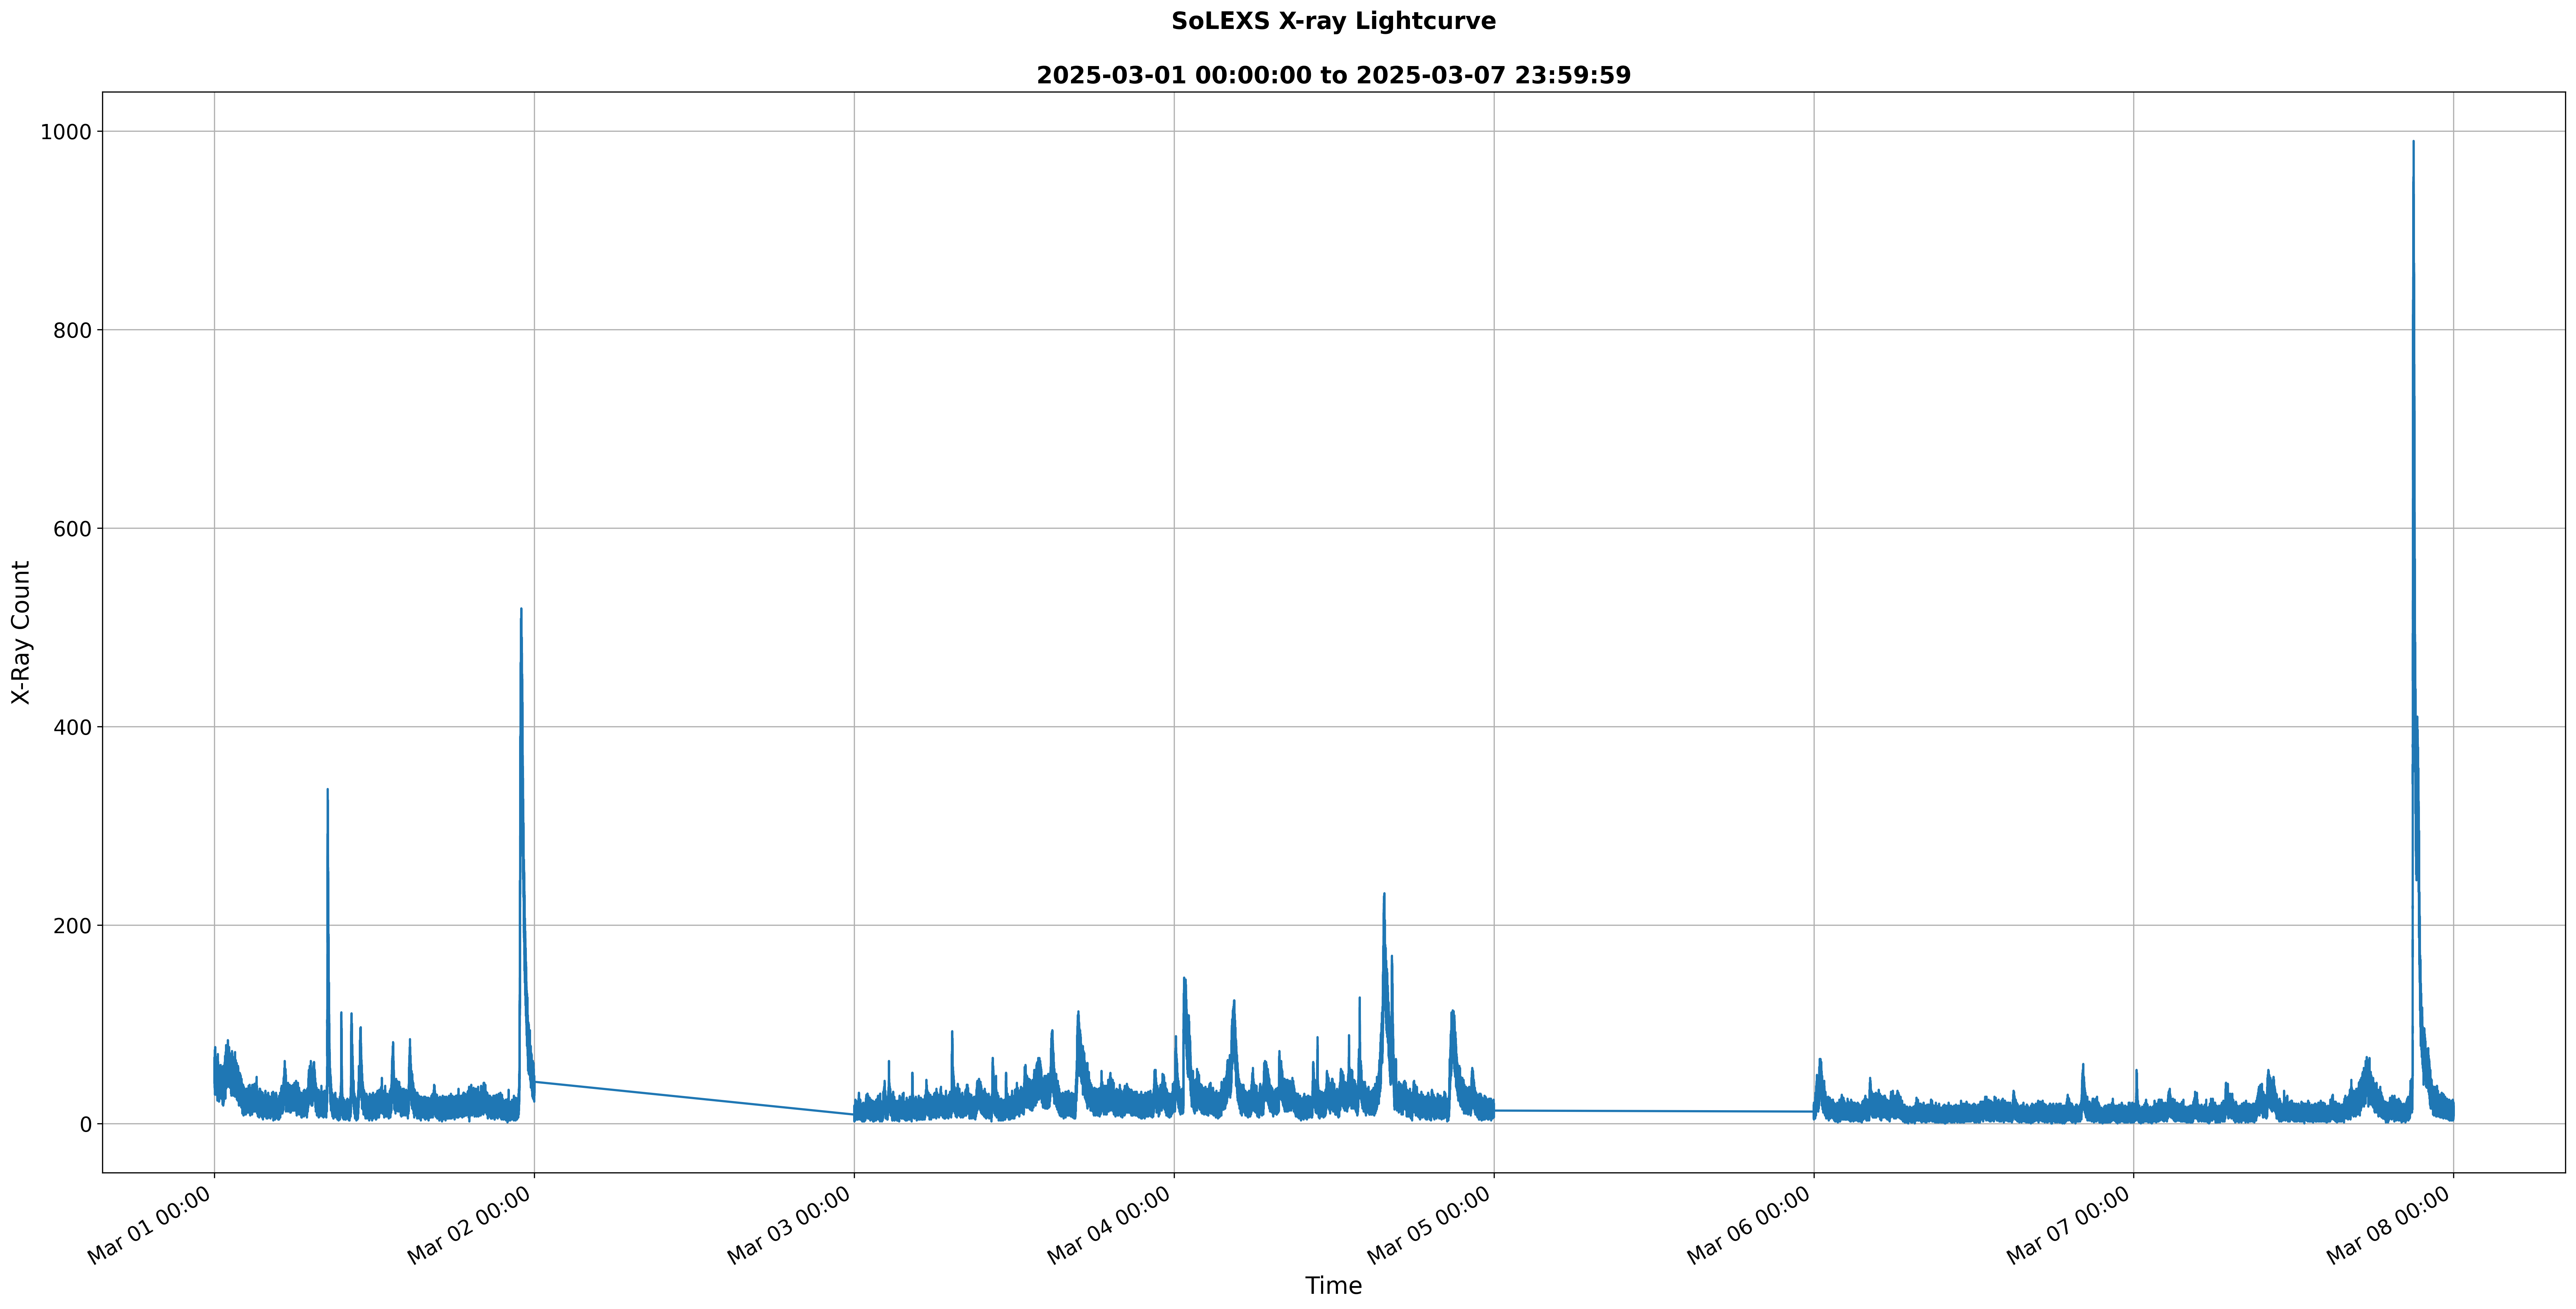

In [74]:
start_time = Time(times.iloc[0], format='unix').to_datetime().strftime('%H:%M:%S')
end_time = Time(times.iloc[-1], format='unix').to_datetime().strftime('%H:%M:%S')

plt_times = Time(times, format='unix').to_datetime()
plt.figure(figsize=(30, 15), dpi=300)
plt.plot(plt_times, counts)
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
plt.grid(True)
plt.xlabel("Time", fontsize=16)
plt.ylabel("X-Ray Count", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f"SoLEXS X-ray Lightcurve\n\n{start_date} {start_time} to {end_date} {end_time}", fontsize=16, fontweight='bold')
plt.show()

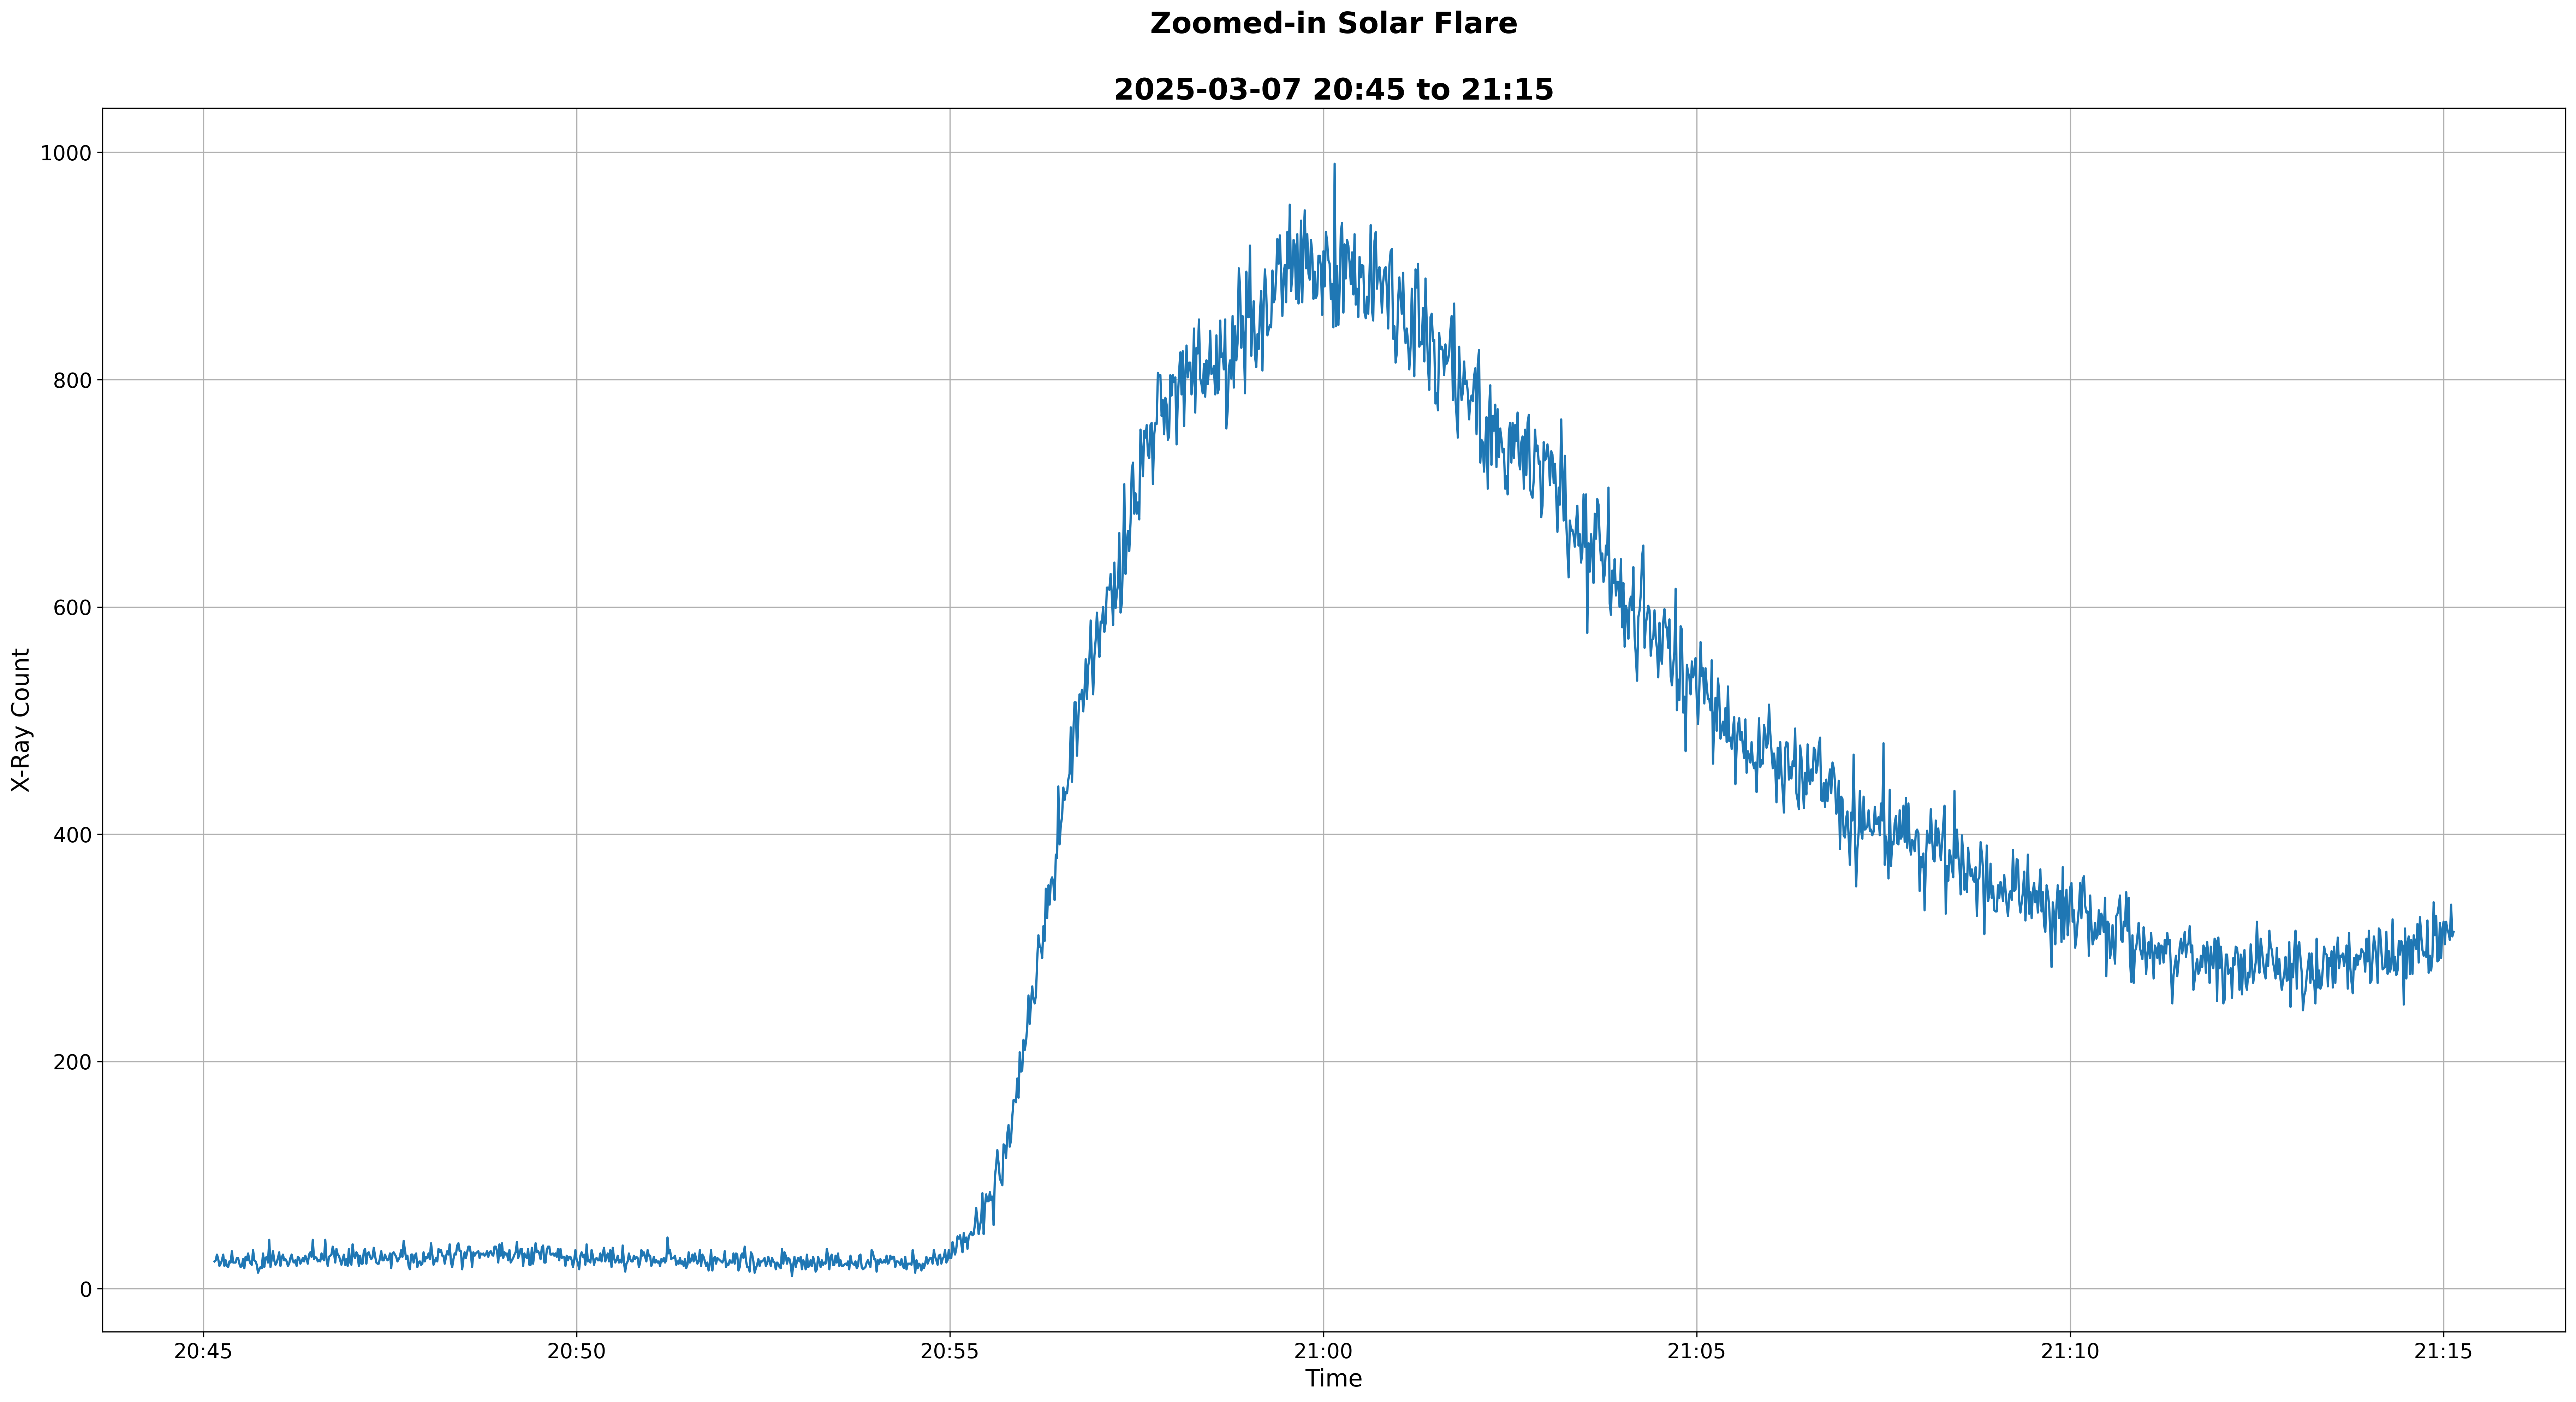

In [75]:
peak_idx = np.nanargmax(df['COUNTS'])
window = 60*15  # seconds around peak
start = peak_idx - window
end = peak_idx + window

time_subset = Time(df['TIME'][start:end], format='unix').to_datetime()

plt.figure(figsize=(30, 15), dpi=300)
plt.plot(time_subset, df['COUNTS'][start:end])
plt.grid(True)
plt.xlabel("Time", fontsize=16)
plt.ylabel("X-Ray Count", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f"Zoomed-in Solar Flare\n\n{df['DATE'].iloc[-1].strftime('%Y-%m-%d')} {time_subset[0].strftime('%H:%M')} to {time_subset[-1].strftime('%H:%M')}", fontsize=20, fontweight='bold')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()